## **ARIMA-TimeSeries Analysis of Tractor Sales** ####

In this case study example, we will learn about time series analysis for a manufacturing operation. Time series analysis and modeling have many business and social applications. It is extensively used to forecast company sales, product demand, stock market trends, agricultural production etc.

The fundamental idea for time series analysis is to decompose the original time series (sales, stock market trends, etc.) into several independent components. Typically, business time series are divided into the following four components:

Trend – overall direction of the series i.e. upwards, downwards etc.

Seasonality – monthly or quarterly patterns

Cycle – long-term business cycles, they usually come after 5 or 7 years

Irregular remainder – random noise left after extraction of all the components

Interference of these components produces the final series.

Why bother decomposing the original / actual time series into components? It is much easier to forecast the individual regular patterns produced through decomposition of time series than the actual series.

In [3]:
import warnings
import itertools

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import seaborn as sns
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [5]:
plt.style.use('bmh')

#### **Problem Definition**
PowerHorse, a tractor and farm equipment manufacturing company, was established a few years after World War II. The company has shown a consistent growth in its revenue from tractor sales since its inception. However, over the years the company has struggled to keep it’s inventory and production cost down because of variability in sales and tractor demand. The management at PowerHorse is under enormous pressure from the shareholders and board to reduce the production cost. Additionally, they are also interested in understanding the impact of their marketing and farmer connect efforts towards overall sales. In the same effort, they have hired us as a data science and predictive analytics consultant.

We will develop an ARIMA model to forecast sale / demand of tractor for next 3 years. Additionally, We will also investigate the impact of marketing program on sales by using an exogenous variable ARIMA model.

As a part of this project, one of the production units we are analysing is based in South East Asia. This unit is completely independent and caters to neighbouring geographies. This unit is just a decade and a half old. In 2014 , they captured 11% of the market share, a 14% increase from the previous year. However, being a new unit they have very little bargaining power with their suppliers to implement Just-in-Time (JiT) manufacturing principles that have worked really well in PowerHorse’s base location. Hence, they want to be on top of their production planning to maintain healthy business margins. Monthly sales forecast is the first step we have suggested to this unit towards effective inventory management.

The MIS team shared the month on month (MoM) sales figures (number of tractors sold) for the last 12 years in the tractor-sales.csv file.

##### **Step 1: Visualize Tractor Sales data as time series**


In [7]:
sales_data = pd.read_csv('data/tractor-sales.csv')
sales_data.head()

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203


In [8]:
# since the complete date was not mentioned, we assume that it was the first of every month
dates = pd.date_range(start= '2003-01-01', freq= 'MS', periods = len(sales_data))

In [9]:
import calendar
sales_data['Month'] = dates.month
sales_data['Month'] = sales_data['Month'].apply(lambda x: calendar.month_abbr[x])
sales_data['Year'] = dates.year

In [10]:
sales_data.drop(['Month-Year'], axis= 1, inplace=True)
sales_data.rename(columns= {'Number of Tractor Sold': 'Tractor_sales'}, inplace=True)
sales_data = sales_data[['Month', 'Year', 'Tractor_sales']]

In [11]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
sales_data.set_index(dates, inplace=True)

In [12]:
sales_data.head(5)

,Month,Year,Tractor_sales
2003-01-01,Jan,2003,141
2003-02-01,Feb,2003,157
2003-03-01,Mar,2003,185
2003-04-01,Apr,2003,199
2003-05-01,May,2003,203


In [13]:
# extract out the time series
sales_ts = sales_data['Tractor_sales']

Text(0, 0.5, 'Tractor_sales')

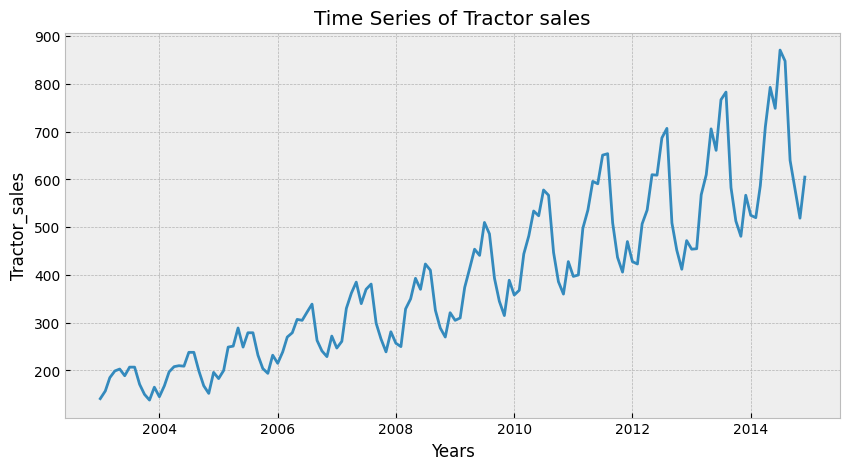

In [15]:
plt.figure(figsize=(10,5))
plt.title('Time Series of Tractor sales')
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Tractor_sales')

Now we start with time series decomposition of this data to understand underlying patterns such as trend, seasonality, cycle and irregular remainder for tractor sales.

In the above data, a cyclic pattern seems to be non-existent since the unit we are analysing is a relatively new unit to notice business cycles. Also in theory, business cycles in traditional businesses are observed over a period of 7 or more years. Hence, we won’t include business cycles in this time series decomposition exercise. Also, we observe a overall increasing trend across years.

**Step 1.1: Trend - Time Series Decomposition**

We will try to decipher trends embedded in the above tractor sales time series. It is clearly evident that there is an overall increasing trend in the data along with some seasonal variations. Hence, we can check stationarity using the following:

1. Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance we mean that at any instant 't', we'll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

2. Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

3. Moving Average - The idea with moving average is to remove all the zigzag motion (wrinkles) from the time series to produce a steady trend through averaging adjacent values of a time period.


We will take moving average of different time periods i.e. 4,6,8, and 12 months as shown below. Here, moving average is shown in red and actual series in blue.

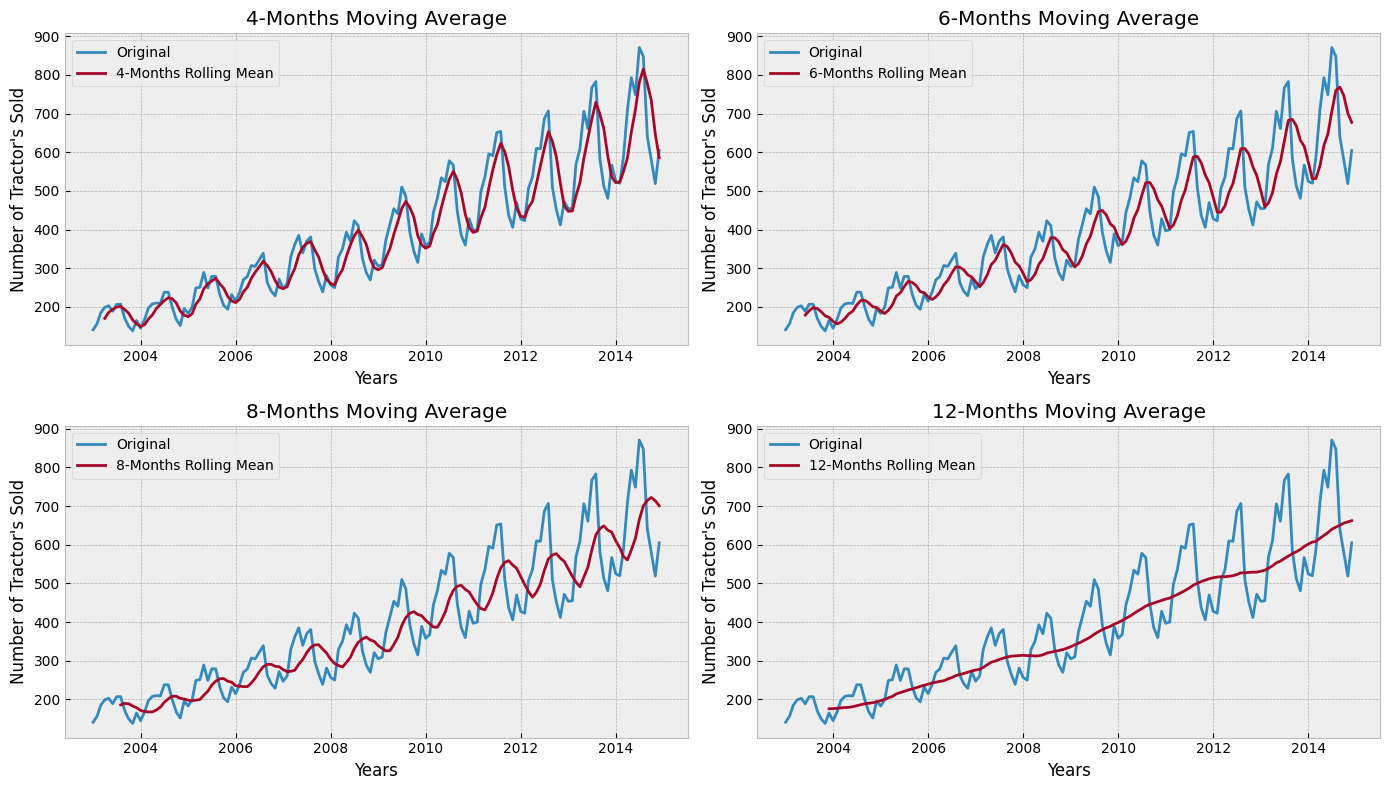

In [16]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)
axes[0][0].plot(sales_ts.index, sales_ts, label='Original')
axes[0][0].plot(sales_ts.index, sales_ts.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Number of Tractor's Sold")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')
axes[0][1].plot(sales_ts.index, sales_ts, label='Original')
axes[0][1].plot(sales_ts.index, sales_ts.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Number of Tractor's Sold")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')
axes[1][0].plot(sales_ts.index, sales_ts, label='Original')
axes[1][0].plot(sales_ts.index, sales_ts.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Number of Tractor's Sold")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')
axes[1][1].plot(sales_ts.index, sales_ts, label='Original')
axes[1][1].plot(sales_ts.index, sales_ts.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Number of Tractor's Sold")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')
plt.tight_layout()
plt.show()

As we could see in the above plots, 12-month moving average could produce a wrinkle free curve as desired. This on some level is expected since we are using month-wise data for our analysis and there is expected monthly-seasonal effect in our data.

Plot the rolling mean and standard deviation on window of 12 months.

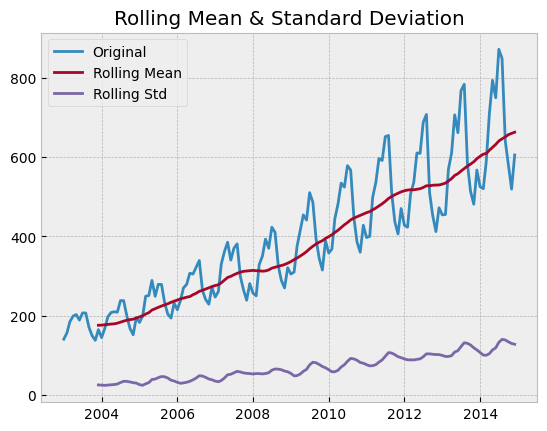

In [17]:
#Determing rolling statistics
rolmean = sales_ts.rolling(window=12).mean()
rolstd = sales_ts.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(sales_ts, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

**Dickey-Fuller Test** - Run the Dicky Fuller Test on the timeseries and verify the null hypothesis that the TS is non-stationary.

In [18]:
from statsmodels.tsa.stattools import adfuller
print("Results of Dickey-Fuller test:")
dftest = adfuller(sales_ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller test:
Test Statistic                   1.108825
p-value                          0.995291
#lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series. Also, the test statistic is way more than the critical values. Note that the signed values should be compared and not the absolute values.

As we observed while plotting the moving average over months that there is a monthly pattern.

**Step 1.2: Seasonality – Time Series Decomposition**

The first thing to do is to see how number of tractors sold vary on a month on month basis. We will plot a stacked annual plot to observe seasonality in our data.

In [19]:
monthly_sales_data = pd.pivot_table(sales_data, values='Tractor_sales', columns = "Year", index = "Month")
monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Month,,,,,,,,,,,,
Jan,141.0,145.0,183.0,215.0,247.0,257.0,305.0,358.0,397.0,428.0,454.0,525.0
Feb,157.0,168.0,200.0,239.0,261.0,250.0,310.0,368.0,400.0,423.0,455.0,520.0
Mar,185.0,197.0,249.0,270.0,330.0,329.0,374.0,444.0,498.0,507.0,568.0,587.0
Apr,199.0,208.0,251.0,279.0,362.0,350.0,414.0,482.0,536.0,536.0,610.0,710.0
May,203.0,210.0,289.0,307.0,385.0,393.0,454.0,534.0,596.0,610.0,706.0,793.0
Jun,189.0,209.0,249.0,305.0,340.0,370.0,441.0,524.0,591.0,609.0,661.0,749.0
Jul,207.0,238.0,279.0,322.0,370.0,423.0,510.0,578.0,651.0,687.0,767.0,871.0
Aug,207.0,238.0,279.0,339.0,381.0,410.0,486.0,567.0,654.0,707.0,783.0,848.0
Sep,171.0,199.0,232.0,263.0,299.0,326.0,393.0,447.0,509.0,509.0,583.0,640.0


<Axes: xlabel='Month'>

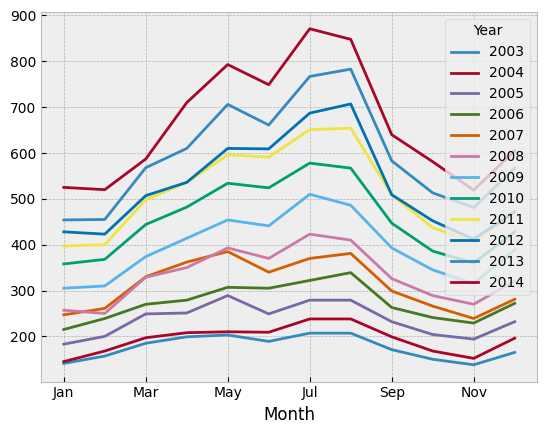

In [20]:
monthly_sales_data.plot()

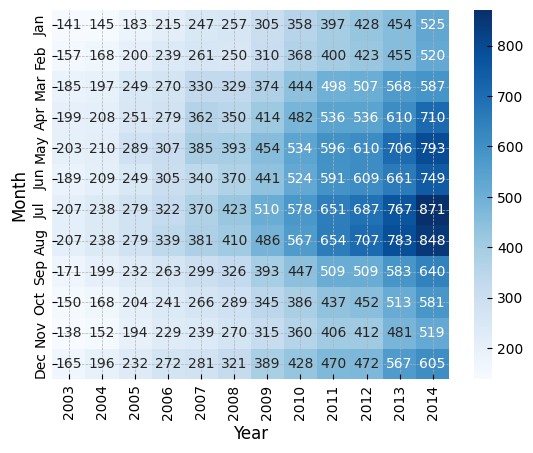

In [24]:
# Another way of looking at above graph through Heatmap
sns.heatmap(monthly_sales_data, annot=True, cmap='Blues', fmt='g');

In [25]:
# Transposed view of monthly_sales_data
monthly_sales_data.T

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2003,141.0,157.0,185.0,199.0,203.0,189.0,207.0,207.0,171.0,150.0,138.0,165.0
2004,145.0,168.0,197.0,208.0,210.0,209.0,238.0,238.0,199.0,168.0,152.0,196.0
2005,183.0,200.0,249.0,251.0,289.0,249.0,279.0,279.0,232.0,204.0,194.0,232.0
2006,215.0,239.0,270.0,279.0,307.0,305.0,322.0,339.0,263.0,241.0,229.0,272.0
2007,247.0,261.0,330.0,362.0,385.0,340.0,370.0,381.0,299.0,266.0,239.0,281.0
2008,257.0,250.0,329.0,350.0,393.0,370.0,423.0,410.0,326.0,289.0,270.0,321.0
2009,305.0,310.0,374.0,414.0,454.0,441.0,510.0,486.0,393.0,345.0,315.0,389.0
2010,358.0,368.0,444.0,482.0,534.0,524.0,578.0,567.0,447.0,386.0,360.0,428.0
2011,397.0,400.0,498.0,536.0,596.0,591.0,651.0,654.0,509.0,437.0,406.0,470.0


<Axes: >

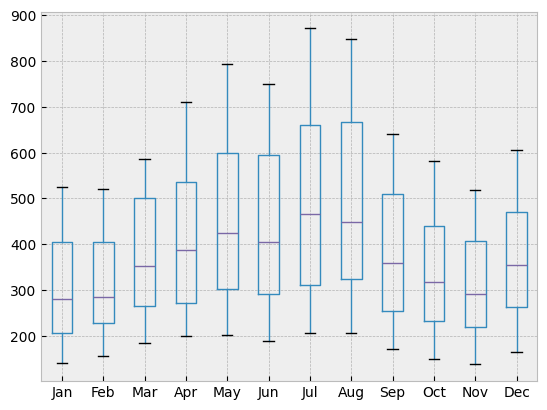

In [26]:
monthly_sales_data.T.boxplot()

**Important Inferences**

1. The year on year trend clearly shows that the tractor sales have been increasing without fail.
2. The variance and the mean value in July and August is much higher than rest of the months. There is a fairly consistent month on month variation with July and August as the peak months for tractor sales.
3. Even though the mean value of each month is quite different their variance is small. Hence, we have strong seasonal effect with a cycle of 12 months or less.

**Step 1.3: Irregular Remainder – Time Series Decomposition**

To decipher underlying patterns in tractor sales, we build a multiplicative time series decomposition model. Instead of multiplicative model we could have chosen additive model as well.

However, it would have made very little difference in terms of conclusion we will draw from this time series decomposition. Additionally, we are also aware that plain vanilla decomposition models like these are rarely used for forecasting. Their primary purpose is to understand underlying patterns in temporal data to use in more sophisticated analysis like Holt-Winters seasonal method or ARIMA.

In [27]:
decomposition = sm.tsa.seasonal_decompose(sales_ts, model='multiplicative')

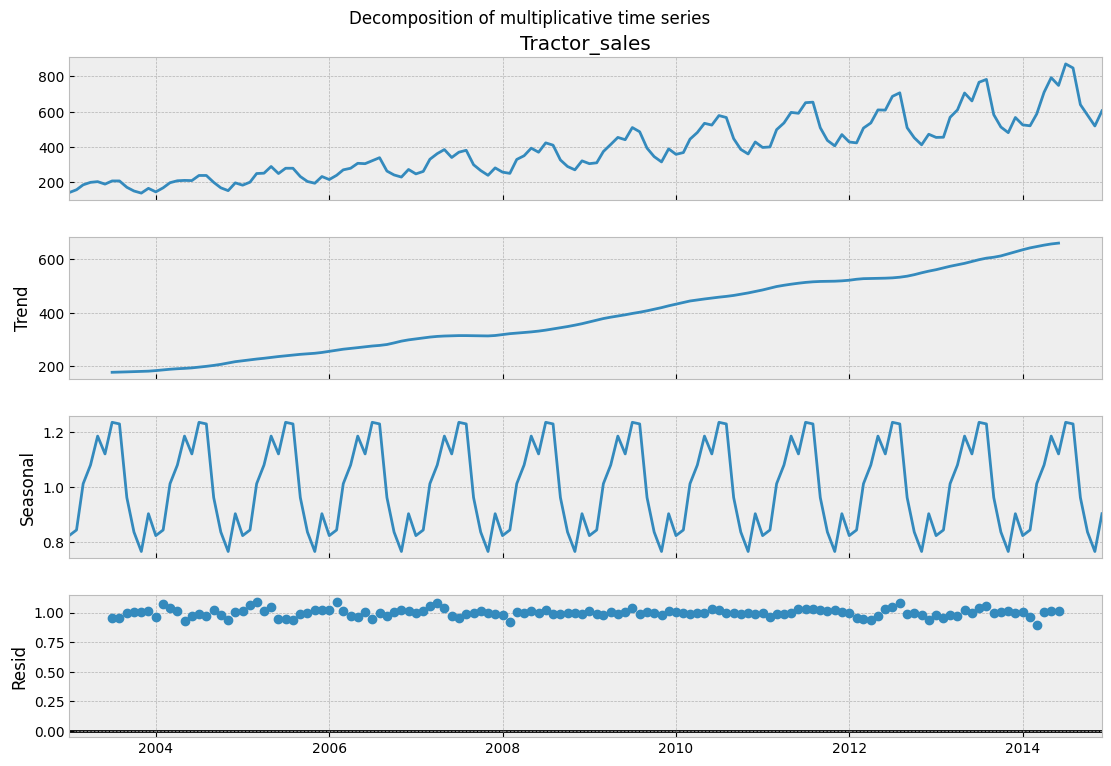

In [28]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()


The following are some of our key observations from this analysis:

1) Trend: 12-months moving average looks quite similar to a straight line hence we could have easily used linear regression to estimate the trend in this data.

2) Seasonality: as discussed, seasonal plot displays a fairly consistent month-on-month pattern. The monthly seasonal components are average values for a month after removal of trend.

3) Irregular Remainder (random): is the residual left in the series after removal of trend and seasonal components. 

The expectations from remainder component is that it should look like a white noise i.e. displays no pattern at all. However, for our series residual display some pattern with high variation on the edges of data i.e. near the beginning (2004-07) and the end (2013-14) of the series.

#### **ARIMA Modeling**

ARIMA is a combination of 3 parts i.e. AR (AutoRegressive), I (Integrated), and MA (Moving Average). A convenient notation for ARIMA model is ARIMA(p,d,q). Here p,d, and q are the levels for each of the AR, I, and MA parts. Each of these three parts is an effort to make the final residuals display a white noise pattern (or no pattern at all). In each step of ARIMA modeling, time series data is passed through these 3 parts to produce pattern-less residual. The sequence of three passes for ARIMA analysis is as following:

##### **Step 2: Difference data to make data stationary on mean (remove trend)**
The next thing to do is to make the series stationary by removing the upward trend through 1st order differencing of the series.

Text(0, 0.5, 'Tractor Sales')

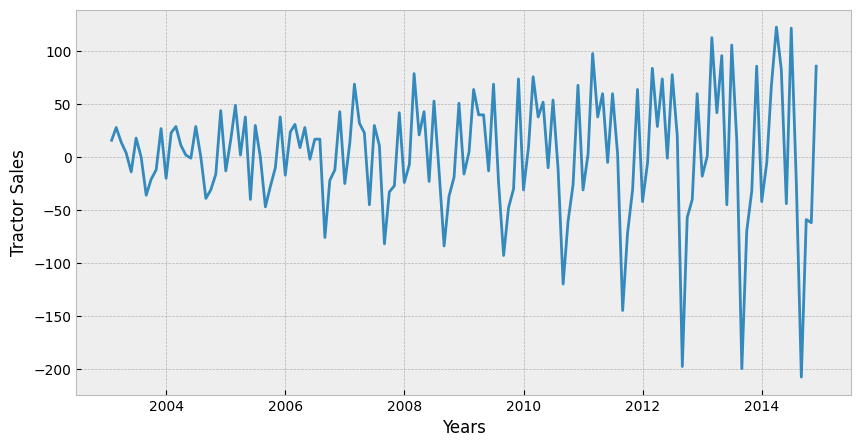

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(sales_ts.diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

Okay so the above series is not stationary on variance i.e. variation in the plot is increasing as we move towards the right of the chart. We need to make the series stationary on variance to produce reliable forecasts through ARIMA models.

##### **Step 3: log transform data to make data stationary on variance**

One of the best ways to make a series stationary on variance is through transforming the original series through log transform. We will go back to our original tractor sales series and log transform it to make it stationary on variance. Notice, this series is not stationary on mean since we are using the original data without differencing. But now the series looks stationary on variance.

Text(0, 0.5, 'Log (Tractor Sales)')

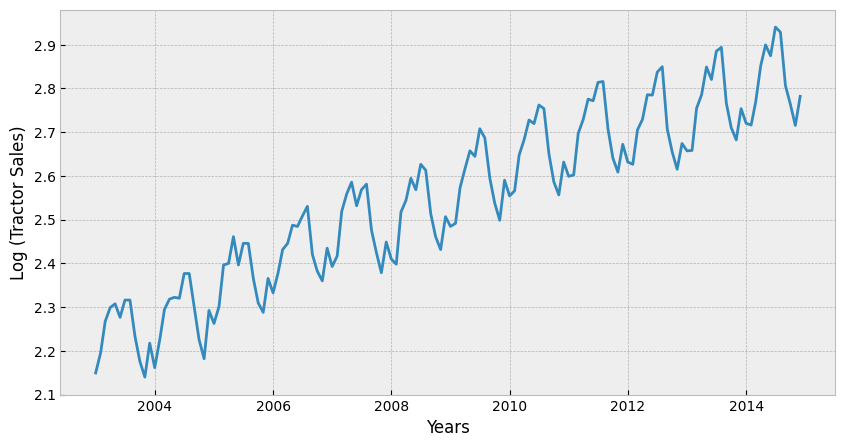

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(sales_ts))
plt.xlabel('Years')
plt.ylabel('Log (Tractor Sales)')

#### **Step 4: Difference log transform data to make data stationary on both mean and variance**

Let us look at the differenced plot for log transformed series to reconfirm if the series is actually stationary on both mean and variance.

Text(0, 0.5, 'Differenced Log (Tractor Sales)')

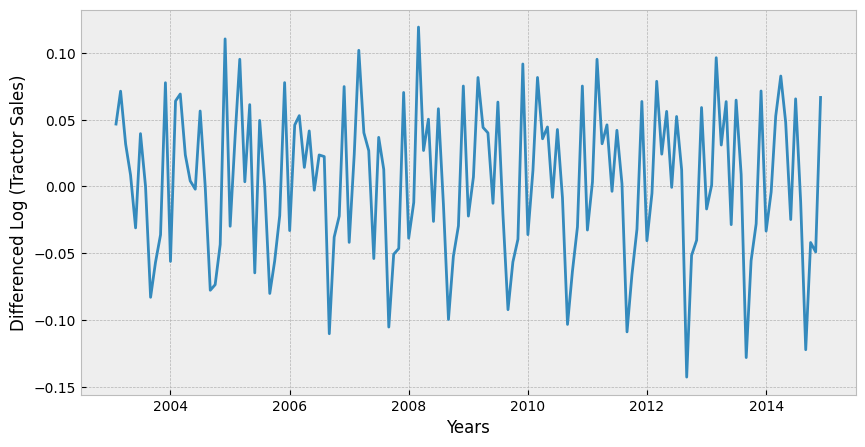

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(sales_ts).diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Differenced Log (Tractor Sales)')

Yes, now this series looks stationary on both mean and variance. This also gives us the clue that I or integrated part of our ARIMA model will be equal to 1 as 1st difference is making the series stationary.

#### **Step 5: Plot ACF and PACF to identify potential AR and MA model**

Now, let us create autocorrelation factor (ACF) and partial autocorrelation factor (PACF) plots to identify patterns in the above data which is stationary on both mean and variance. The idea is to identify presence of AR and MA components in the residuals.

In [33]:
sales_ts_log = np.log10(sales_ts)
sales_ts_log.dropna(inplace=True)

sales_ts_log_diff = sales_ts_log.diff(periods=1) # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
sales_ts_log_diff.dropna(inplace=True)

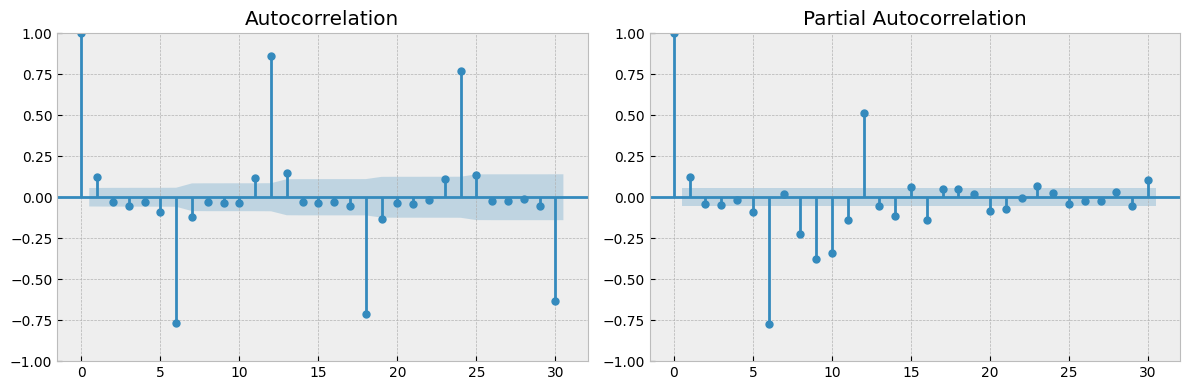

In [34]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_ts_log_diff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(sales_ts_log_diff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

Since, there are enough spikes in the plots outside the insignificant zone (dotted horizontal lines) we can conclude that the residuals are not random. This implies that there information available in residuals to be extracted by AR and MA models. Also, there is a seasonal component available in the residuals at the lag 12 (represented by spikes at lag 12). This makes sense since we are analyzing monthly data that tends to have seasonality of 12 months because of patterns in tractor sales.

#### **Step 6: Identification of best fit ARIMA model**

When looking to fit time series data with a seasonal ARIMA model, our first goal is to find the values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest. We will use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest.

In [35]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [36]:
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 1, 1)x(1, 0, 1, 12)12 model - AIC:-733.7745860583666


Akaike Information Criterion (AIC) - AIC is an effort to balance the model between goodness-of-fit and number of parameters used in the model. 

For the given model, the maximized value of the likelihood function representing goodness-of-fit, and the number of estimated parameters. 

As expected, our model has I (or integrated) component equal to 1. This represents differencing of order 1. There is additional differencing of lag 12 in the above best fit model. Moreover, the best fit model has MA value of order 1. Also, there is seasonal MA with lag 12 of order 1.

##### **Step 7: Predict sales on in-sample date using the best fit ARIMA model**

The next step is to predict tractor sales for in-sample data and find out how close is the model prediction on the in-sample data to the actual truth.

In [38]:
best_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                      order=(0, 1, 1),
                                      seasonal_order=(1, 0, 1, 12),
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
best_results = best_model.fit()

In [39]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                     SARIMAX Results                                      
Dep. Variable:                      Tractor_sales   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 370.887
Date:                            Tue, 19 Aug 2025   AIC                           -733.775
Time:                                    15:21:51   BIC                           -721.923
Sample:                                01-01-2003   HQIC                          -728.959
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3575      0.069     -5.199      0.000      -0.492      -0.223
ar.S.L12       0.9933      0.006   

In [40]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [41]:
# Extract the predicted and true values of our time series
sales_ts_forecasted = pred_dynamic.predicted_mean
sales_ts_truth = sales_ts_log['2012-01-01':]

# Compute the mean square error
mse = ((sales_ts_forecasted - sales_ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

The Mean Squared Error of our forecasts is 0.0011


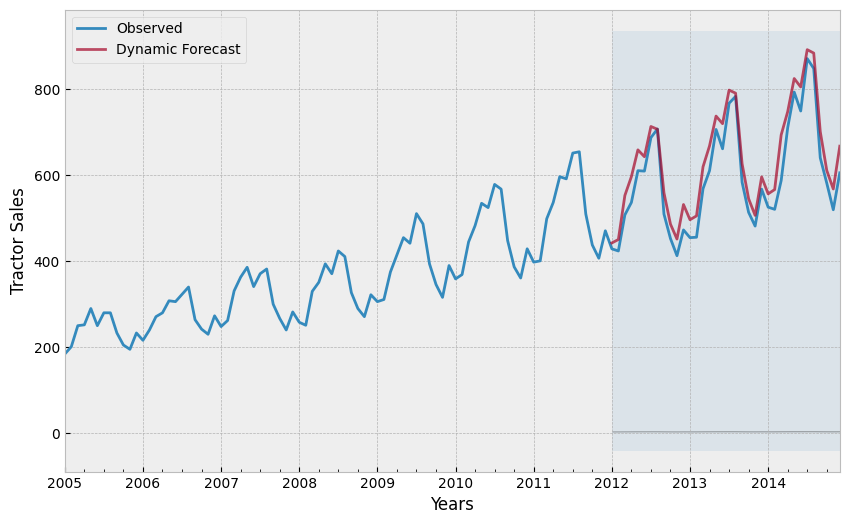

In [42]:
axis = sales_ts['2005':].plot(label='Observed', figsize=(10, 6))
np.power(10, pred_dynamic.predicted_mean).plot(ax=axis, label='Dynamic Forecast', alpha=0.7)
axis.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
axis.fill_betweenx(axis.get_ylim(), pd.to_datetime('2012-01-01'), sales_ts.index[-1], alpha=.1, zorder=-1)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()
plt.close()

##### **Step 8: Forecast sales using the best fit ARIMA model**

The next step is to predict tractor sales for next 3 years i.e. for 2015, 2016, and 2017 through the above model.

In [43]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [44]:
n_steps = 36
idx = pd.date_range(sales_ts.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2014-12-01,567.465114,528.226260,609.618795,528.226260,609.618795
2015-01-01,566.207968,519.981638,616.543816,519.981638,616.543816
2015-02-01,668.837971,607.121360,736.828352,607.121360,736.828352
2015-03-01,755.208084,678.437691,840.665631,678.437691,840.665631
2015-04-01,850.223569,756.598206,955.434618,756.598206,955.434618


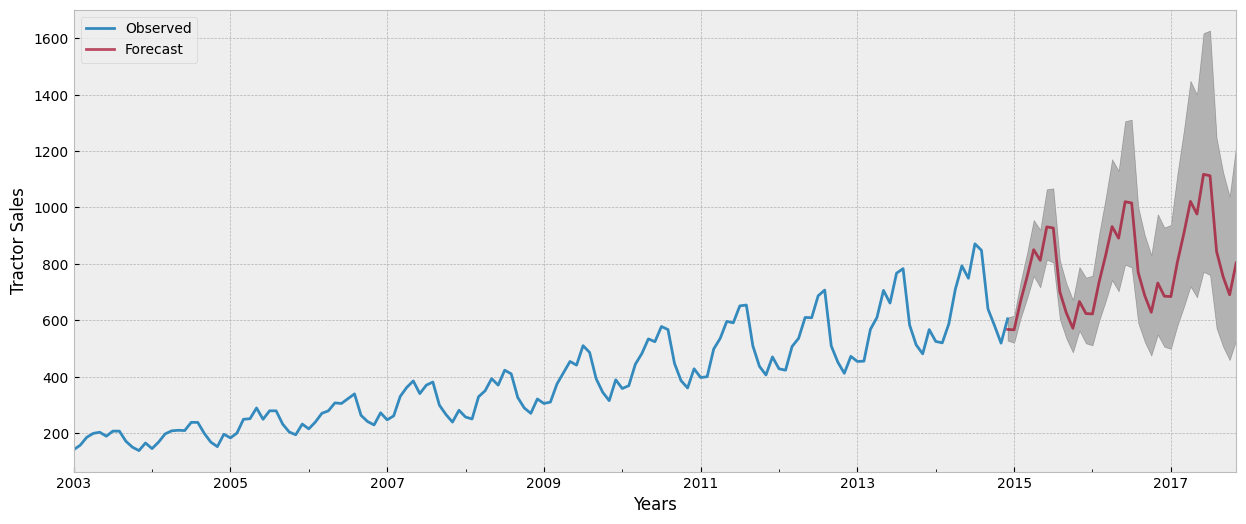

In [45]:
# plot the forecast along with the confidence band
axis = sales_ts.plot(label='Observed', figsize=(15, 6))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)
#axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='k', alpha=.75)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()

The major assumption here is that the underlining patterns in the time series will continue to stay the same as predicted in the model. A short-term forecasting model, say a couple of business quarters or a year, is usually a good idea to forecast with reasonable accuracy. A long-term model like the one above needs to evaluated on a regular interval of time (say 6 months). The idea is to incorporate the new information available with the passage of time in the model.

##### **Step 9: Plot ACF and PACF for residuals of ARIMA model to ensure no more information is left for extraction**

Finally, let’s create an ACF and PACF plot of the residuals of our best fit ARIMA model i.e. ARIMA(0,1,1)(1,0,1).

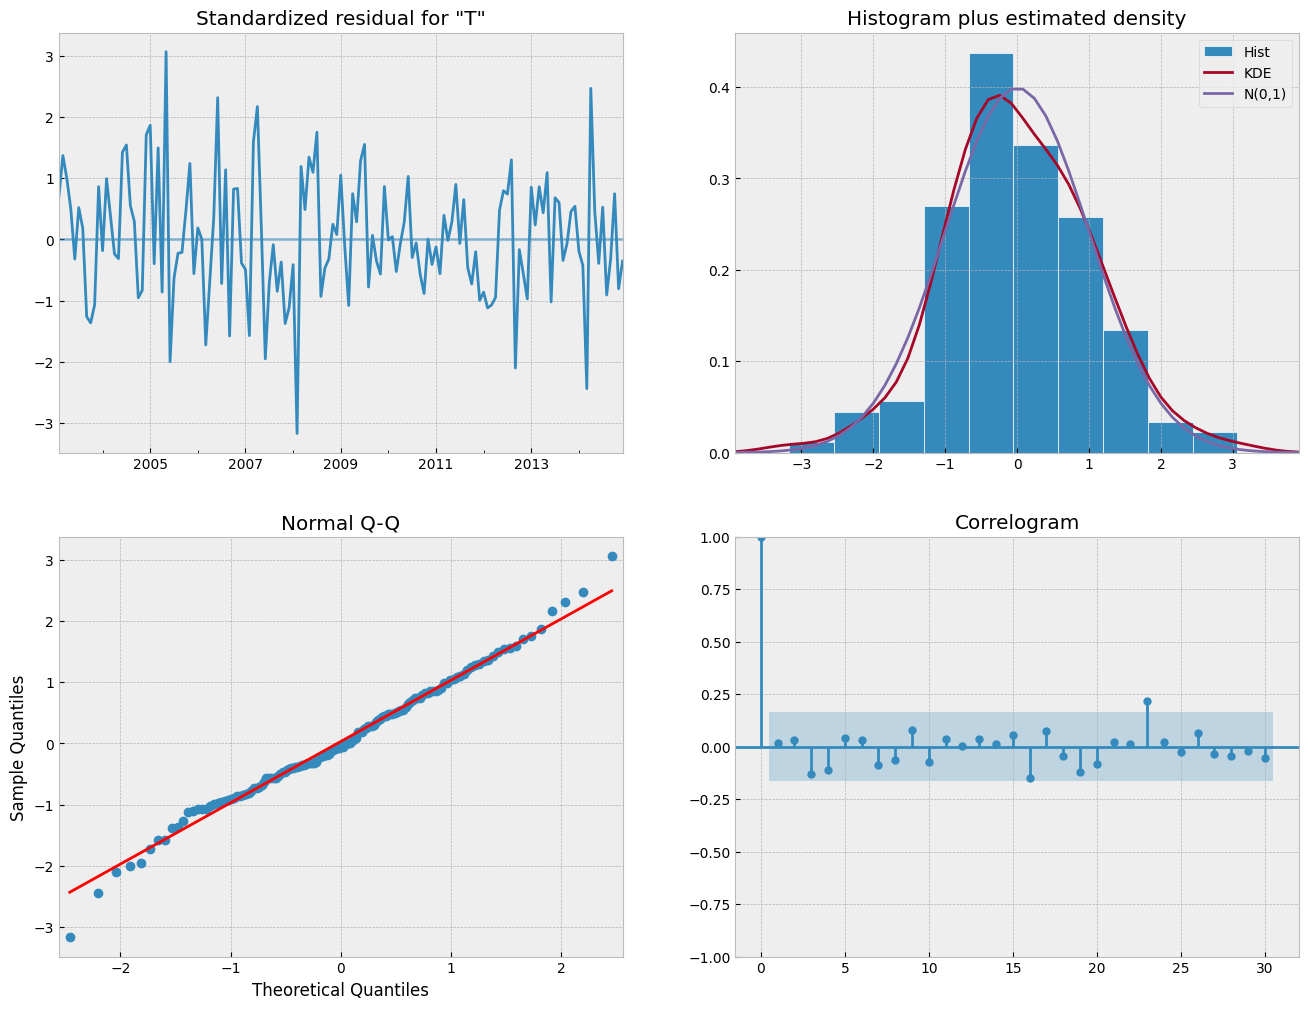

In [46]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations coupled with the fact that there are no spikes outside the insignificant zone for both ACF and PACF plots lead us to conclude that that residuals are random with no information in them and our model produces a satisfactory fit that could help us understand our time series data and forecast future values. It seems that our ARIMA model is working fine.

##### **Step 10: Regression with ARIMA Errors**

For the last 4 years, PowerHorse tractors is running an expensive marketing and farmer connect program to boost their sales. They are interested in learning the impact of this program on overall sales. As a data science consultant we are helping them with this effort. This is an interesting problem and requires a thorough analysis followed by creative solutions and scientific monitoring mechanism. To begin with we will build models based on regression with ARIMA errors and compare them with the pure play ARIMA model. This analysis will provide some clues towards effectiveness of the marketing program. However, this analysis will not be conclusive for finding shortcomings and enhancements for the program which will require further analysis and creative solutions.

In [47]:
mkt_sales_data = pd.read_csv('data/sales-and-marketing.csv')

# since the complete date was not mentioned, we assume that it was the first of every month
mkt_sales_data.set_index(pd.date_range(start='2011-01-01', freq='MS', periods=len(mkt_sales_data)), inplace=True)
mkt_sales_data.drop(['Time Period'], axis=1, inplace=True)
mkt_sales_data.rename(columns={'Sales':'Tractor-Sales'}, inplace=True)
mkt_sales_data.head(5)

,Tractor-Sales,Marketing Expense
2011-01-01,397,486.64
2011-02-01,400,501.80
2011-03-01,498,437.09
2011-04-01,536,565.16
2011-05-01,596,744.15


To begin with, we plot the following scatter plot of same months marketing expense and tractors sales.

Text(0, 0.5, 'Monthly Tractor Sales')

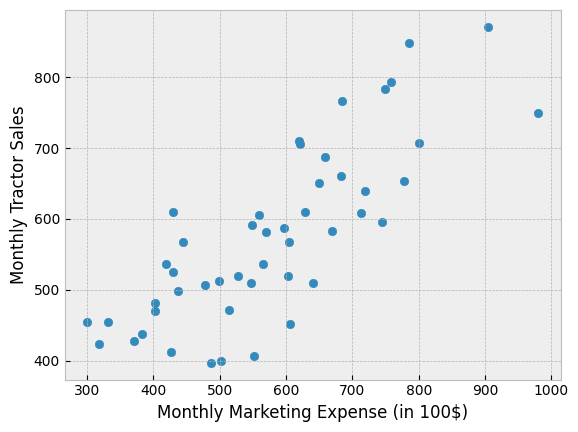

In [48]:
plt.figure()
plt.scatter(x=mkt_sales_data['Marketing Expense'], y=mkt_sales_data['Tractor-Sales'])
plt.xlabel('Monthly Marketing Expense (in 100$)')
plt.ylabel('Monthly Tractor Sales')

In [49]:
print("Correlation for Marketing Data: {}".format(round(mkt_sales_data.corr()['Marketing Expense']['Tractor-Sales'], 2)))

Correlation for Marketing Data: 0.8


This looks promising with quite a high correlation coefficient (p > 0.8). However, there is a lurking danger in analyzing non-stationary time series data. Since two uncorrelated series can display high correlation because of time series trend in data. In this case, PowerHorse is a growing company and the latent factor is 'growth' of the company. Hence both its sales and marketing expenses can be on an upward curve independent of each other. To investigate that a better way is to find the correlation between stationary data obtained through differencing of marketing expediture and the trator sales data individually.

The following is the correlation plot for stationary data:

Text(0, 0.5, 'Differenced Tractor Sales')

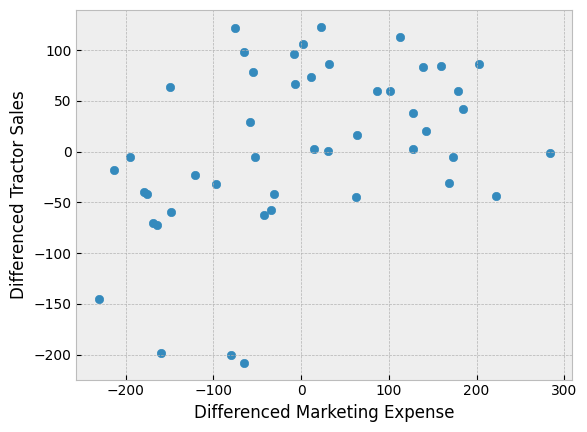

In [50]:
mkt_sales_data_diff = mkt_sales_data.diff(periods=1)
mkt_sales_data_diff.dropna(inplace=True)

plt.figure()
plt.scatter(x=mkt_sales_data_diff['Marketing Expense'], y=mkt_sales_data_diff['Tractor-Sales'])
plt.xlabel('Differenced Marketing Expense')
plt.ylabel('Differenced Tractor Sales')

In [51]:
print("Correlation for Stationary Data: {}".format(round(mkt_sales_data_diff.corr()['Marketing Expense']['Tractor-Sales'], 2)))


Correlation for Stationary Data: 0.41


Ok, so that near perfect correlation has now disappeared though there is still some correlation in this data (p= 0.41).

Typically, the marketing effort for the previous few months needs to have a good correlation with sales for an effective marketing program. The marketing expense for the last month as displayed below has very little correlation (p= 0.17):

In [52]:
len(mkt_sales_data_diff)


47

In [53]:
prev_months_corr_data = pd.DataFrame(np.column_stack((\
                                        mkt_sales_data_diff['Marketing Expense'][0:46].values,\
                                        mkt_sales_data_diff['Tractor-Sales'][1:47].values)), \
                                     columns=["Previous Month's Differenced Marketing Expense" , 
                                              "Differenced Tractor Sales"])

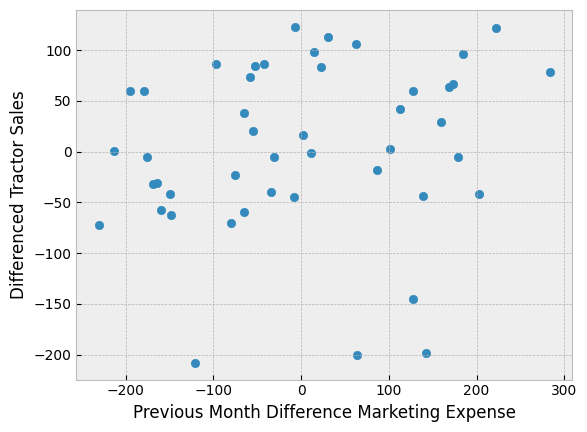

In [54]:
plt.figure()
plt.scatter(x=prev_months_corr_data["Previous Month's Differenced Marketing Expense"], \
            y=prev_months_corr_data["Differenced Tractor Sales"])
plt.xlabel("Previous Month Difference Marketing Expense")
plt.ylabel("Differenced Tractor Sales")
plt.show()

In [55]:
print(
    "Correlation of current Months's Differenced Tractor Sales with Previous Month's Differenced Marketing Expense: {}"\
    .format(round(prev_months_corr_data.corr().iloc[0,1], 2)))

Correlation of current Months's Differenced Tractor Sales with Previous Month's Differenced Marketing Expense: 0.17


The correlation for the previous quarter also shows non-existent correlation with sales. Now, let’s build a regression model with ARIMA error (ARIMAX) model for the current and previous months.

In [56]:
clip_length = len(mkt_sales_data_diff)
clip_length

47

In [57]:
lagged_mkt_exp_diff_sales_data = pd.DataFrame(np.column_stack((\
                                        mkt_sales_data_diff['Marketing Expense'],\
                                        mkt_sales_data_diff['Marketing Expense'].shift(periods=1)[0:clip_length],\
                                        mkt_sales_data_diff['Marketing Expense'].shift(periods=2)[0:clip_length],\
                                        mkt_sales_data_diff['Marketing Expense'].shift(periods=3)[0:clip_length],\
                                        mkt_sales_data_diff['Tractor-Sales'][0:47].values)), \
                                     columns=["Diff_Mkt_Exp", "Diff_Mkt_Exp_Lag_1", "Diff_Mkt_Exp_Lag_2", "Diff_Mkt_Exp_Lag_3", "Diff_Sales"])

In [58]:
lagged_mkt_exp_diff_sales_data.set_index(mkt_sales_data_diff.index, inplace=True)
lagged_mkt_exp_diff_sales_data.head(10)

,Diff_Mkt_Exp,Diff_Mkt_Exp_Lag_1,Diff_Mkt_Exp_Lag_2,Diff_Mkt_Exp_Lag_3,Diff_Sales
2011-02-01,15.16,NaN,NaN,NaN,3.0
2011-03-01,-64.71,15.16,NaN,NaN,98.0
2011-04-01,128.07,-64.71,15.16,NaN,38.0
2011-05-01,178.99,128.07,-64.71,15.16,60.0
2011-06-01,-195.41,178.99,128.07,-64.71,-5.0
2011-07-01,101.47,-195.41,178.99,128.07,60.0
2011-08-01,127.30,101.47,-195.41,178.99,3.0
2011-09-01,-230.40,127.30,101.47,-195.41,-145.0
2011-10-01,-164.30,-230.40,127.30,101.47,-72.0
2011-11-01,168.75,-164.30,-230.40,127.30,-31.0


We now want to create different by considering the different lagged marketing expenditure attributes as regressors and investigate whether previous month's/quarter's affect the tractor sales or not (in other words if we incoporate the marketing efforts does they lower the AIC score or not. We would be building 4 ARIMA models with regressors ranging from current month to last quarter)

In [59]:
import sys

def auto_arima(timeseries, regressors=None, p=range(0, 2), d=range(0, 1), q=range(0, 2)):

    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    warnings.filterwarnings("ignore") # specify to ignore warning messages

    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_results = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:

            try:
                temp_model = sm.tsa.statespace.SARIMAX(endog=timeseries,
                                                 exog=regressors,
                                                 order = param,
                                                 seasonal_order = param_seasonal,
                                                 enforce_stationarity=True,
                                                 enforce_invertibility=True)
                temp_results = temp_model.fit()

                # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
                if temp_results.aic < best_aic:
                    best_aic = temp_results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_results = temp_results
            except:
                #print("Unexpected error:", sys.exc_info()[0])
                continue
                
                

    print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))
    print(best_results.summary().tables[0])
    print(best_results.summary().tables[1])

In [60]:
#ARIMA Model No Regressor
timeseries = lagged_mkt_exp_diff_sales_data["Diff_Sales"][3:47]
regressors = lagged_mkt_exp_diff_sales_data["Diff_Mkt_Exp"][3:47]
auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 1), q=range(0, 2))

Best SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 model - AIC:443.254447794397
                                      SARIMAX Results                                      
Dep. Variable:                          Diff_Sales   No. Observations:                   44
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 12)   Log Likelihood                -217.627
Date:                             Tue, 19 Aug 2025   AIC                            443.254
Time:                                     15:42:51   BIC                            450.391
Sample:                                 05-01-2011   HQIC                           445.901
                                      - 12-01-2014                                         
Covariance Type:                               opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Diff_Mkt_Exp     0.0233      0.039 

In [61]:
#ARIMA Model with 1 month Lag Marekting Sales Data Regressor
timeseries = lagged_mkt_exp_diff_sales_data["Diff_Sales"][3:47]
regressors = lagged_mkt_exp_diff_sales_data[["Diff_Mkt_Exp", "Diff_Mkt_Exp_Lag_1"]][3:47]
auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 1), q=range(0, 2))

Best SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 model - AIC:445.14005342892983
                                      SARIMAX Results                                      
Dep. Variable:                          Diff_Sales   No. Observations:                   44
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 12)   Log Likelihood                -217.570
Date:                             Tue, 19 Aug 2025   AIC                            445.140
Time:                                     15:43:09   BIC                            454.061
Sample:                                 05-01-2011   HQIC                           448.448
                                      - 12-01-2014                                         
Covariance Type:                               opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Diff_Mkt_Exp         

In [62]:
#ARIMA Model with 2 months Lag Marekting Sales Data Regressor
timeseries = lagged_mkt_exp_diff_sales_data["Diff_Sales"][3:47]
regressors = lagged_mkt_exp_diff_sales_data[["Diff_Mkt_Exp", "Diff_Mkt_Exp_Lag_1", "Diff_Mkt_Exp_Lag_2"]][3:47]
auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 1), q=range(0, 2))

Best SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 model - AIC:447.07783776888226
                                      SARIMAX Results                                      
Dep. Variable:                          Diff_Sales   No. Observations:                   44
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 12)   Log Likelihood                -217.539
Date:                             Tue, 19 Aug 2025   AIC                            447.078
Time:                                     15:43:26   BIC                            457.783
Sample:                                 05-01-2011   HQIC                           451.048
                                      - 12-01-2014                                         
Covariance Type:                               opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Diff_Mkt_Exp         

In [63]:
#ARIMA Model with 3 months Lag Marekting Sales Data Regressor
timeseries = lagged_mkt_exp_diff_sales_data["Diff_Sales"][3:47]
regressors = lagged_mkt_exp_diff_sales_data[["Diff_Mkt_Exp", "Diff_Mkt_Exp_Lag_1", "Diff_Mkt_Exp_Lag_2", "Diff_Mkt_Exp_Lag_3"]][3:47]
auto_arima(timeseries, regressors, p=range(0, 2), d=range(0, 1), q=range(0, 2))

Best SARIMAX(1, 0, 0)x(1, 0, 0, 12)12 model - AIC:447.40320160156125
                                     SARIMAX Results                                      
Dep. Variable:                         Diff_Sales   No. Observations:                   44
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -216.702
Date:                            Tue, 19 Aug 2025   AIC                            447.403
Time:                                    15:43:40   BIC                            459.893
Sample:                                05-01-2011   HQIC                           452.035
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Diff_Mkt_Exp           0.0111

Notice AIC, AICc, and BIC values for the plain ARIMA model without marketing expense as predictor variable has lower values of the two models. This indicates that marketing expense is not actually adding value to tractor sales. This is the first indication for the management at PowerHorse to re-evaluate the marketing and farmer connect program. I must point out that evaluation of marketing budgets with a forecasting model like the one we have built is not the best of practices. The best practice is to embed scientific data collection, monitoring, and evaluation mechanism in the design of a marketing program at inception. However, a scientific and well thought out mechanism prior to implementation is often missing in many programs. This is when one could go back in time to use regression with ARIMA error to evaluate effective of marketing programs.